In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from src.utils import load, add_variables, clean_data
from src.preprocessing import DataSet
from src.forecast import NaiveDrift, NaiveLast, NaiveSeasonal, NaiveAVG, TSCV, OLS
from src.ploting import LinearPlot, DistPlot, ACFPlot
from src.utils.hellwig import run_hellwig

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [22]:
CURRENCY = "EURUSD"
INTERVAL = "4h"

## Podział na zbiory train, test, validate

In [23]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_direction', 'target_value'])
train, val, test = data.add_variables().clean_data().normalize(how="standarize").get_tvt_df()

NORMALIZING DATA!!


# Metody naiwne

In [24]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=25,
            test_size=200)

In [25]:
data.data.iloc[-5000:].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2019-08-22 00:00:00 to 2022-10-25 16:00:00
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              5000 non-null   float32
 1   Low               5000 non-null   float32
 2   High              5000 non-null   float32
 3   Close             5000 non-null   float32
 4   Volume            5000 non-null   float32
 5   roi_1             5000 non-null   float32
 6   roi_3             5000 non-null   float32
 7   roi_5             5000 non-null   float32
 8   roi_10            5000 non-null   float32
 9   roi_20            5000 non-null   float32
 10  candle_body_size  5000 non-null   float32
 11  vol_change_1      5000 non-null   float32
 12  vol_change_2      5000 non-null   float32
 13  vol_change_3      5000 non-null   float32
 14  sma_50            5000 non-null   float64
 15  sma_200           5000 non-null   float64
 16  target

In [26]:
results_df = pd.DataFrame(columns=['mape_insample', 'rmspe_insample', 'mape_test', 'rmspe_test'])

def append_result(res: pd.DataFrame, tscv: TSCV):
    results_df = pd.concat([res, pd.DataFrame({'mape_insample': tscv.resid_metrics['mean_absolute_percentage_error'],
                                                    'rmspe_insample': tscv.resid_metrics['rmspe'],
                                                    'mape_test': tscv.error_metrics['mean_absolute_percentage_error'],
                                                    'rmspe_test': tscv.error_metrics['rmspe']},
                                                    index=[tscv.model.__class__.__name__])])
    return results_df

In [27]:
tscv.run(model=NaiveSeasonal(h=200, k=4), h=200, k=4, norm_type="standarize")
results_df = append_result(results_df, tscv)
pred_sns = tscv.predicted
print("sns")

avg = tscv.run(model=NaiveAVG(h=200, T=4), h=200, T=4, norm_type="standarize")
results_df = append_result(results_df, tscv)
pred_avg = tscv.predicted
print("avg")

drift = tscv.run(model=NaiveDrift(h=200), h=200, norm_type="standarize")
results_df = append_result(results_df, tscv)
pred_drift = tscv.predicted
print("drift")

last = tscv.run(model=NaiveLast(h=200), h=200, norm_type="standarize")
results_df = append_result(results_df, tscv)
pred_last = tscv.predicted
print("last")

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

4/17303
204/17303
404/17303
604/17303
804/17303
1004/17303
1204/17303
1404/17303
1604/17303
1804/17303
2004/17303
2204/17303
2404/17303
2604/17303
2804/17303
3004/17303
3204/17303
3404/17303
3604/17303
3804/17303
4004/17303
4204/17303
4404/17303
4604/17303
4804/17303
5004/17303
5204/17303
5404/17303
5604/17303
5804/17303
6004/17303
6204/17303
6404/17303
6604/17303
6804/17303
7004/17303
7204/17303
7404/17303
7604/17303
7804/17303
8004/17303
8204/17303
8404/17303
8604/17303
8804/17303
9004/17303
9204/17303
9404/17303
9604/17303
9804/17303
10004/17303
10204/17303
10404/17303
10604/17303
10804/17303
11004/17303
11204/17303
11404/17303
11604/17303


In [28]:
results_df.applymap(round, ndigits=5)

,mape_insample,rmspe_insample,mape_test,rmspe_test
NaiveSeasonal,0.01524,0.02023,0.01236,0.01460
NaiveAVG,0.01521,0.02020,0.01233,0.01455
NaiveDrift,0.01813,0.04003,0.02058,0.02252
NaiveLast,0.01505,0.02009,0.01271,0.01495


saving: Metody naiwne
saving: Metody naiwne
saving: Metody naiwne
saving: Metody Naiwne
saving: Metody Naiwne
saving: Metody Naiwne


<Axes: title={'center': 'Metody Naiwne'}>

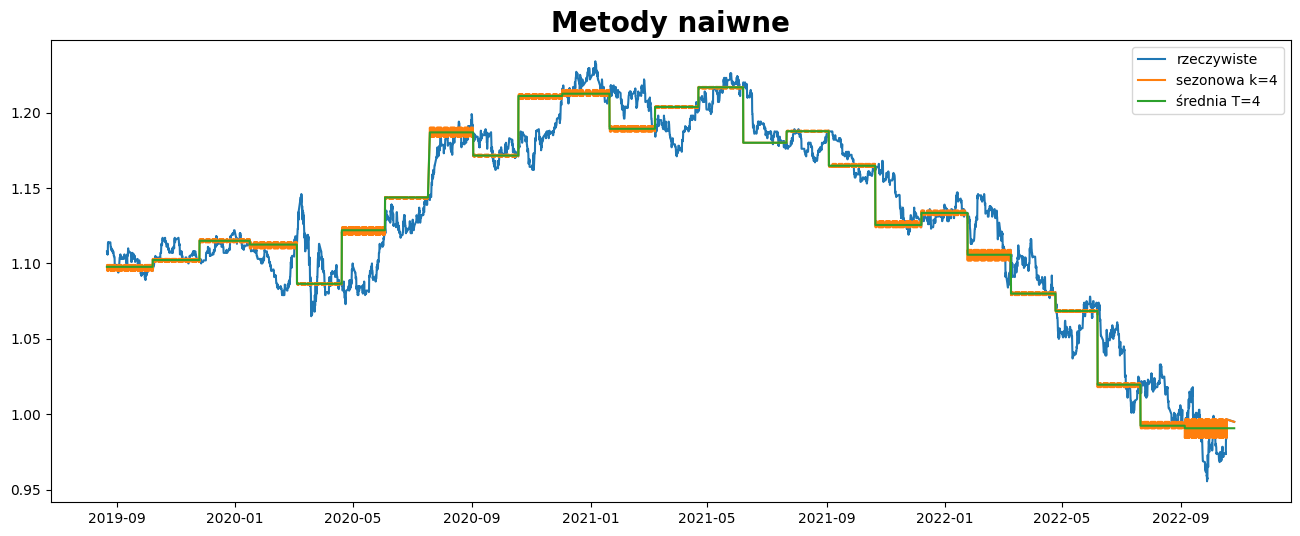

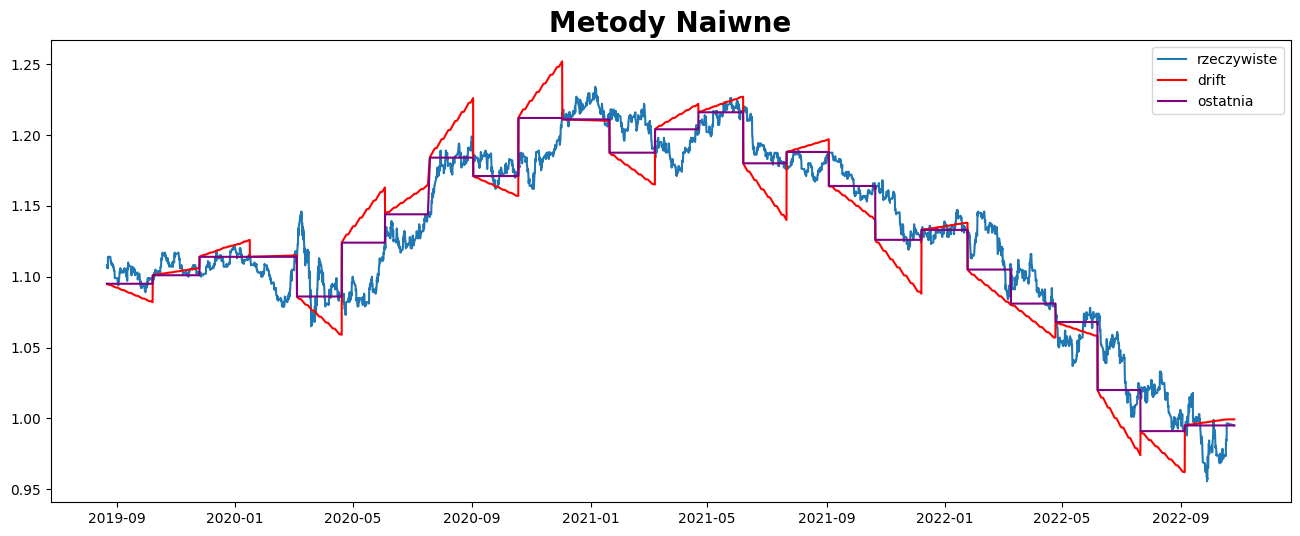

In [29]:
label = 'target_value'
train, test = tscv.dataset.train, tscv.dataset.test

x = tscv.dataset.data.index[-len(pred_avg):]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, label], label="rzeczywiste", title="Metody naiwne")
lp.plot(x, pred_sns, label="sezonowa k=4")
lp.plot(x, pred_avg, label="średnia T=4")

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, label], label="rzeczywiste", title="Metody Naiwne")
lp.plot(x, pred_drift, label="drift", color="red")
lp.plot(x, pred_last, label="ostatnia", color="purple")

# MNK

In [30]:
tscv.run(model=OLS())
results_df = append_result(results_df, tscv)

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

(250, 1)
(500, 1)
(750, 1)
(1000, 1)
(1250, 1)
(1500, 1)
(1750, 1)
(2000, 1)
(2250, 1)
(2500, 1)
(2750, 1)
(3000, 1)
(3250, 1)
(3500, 1)
(3750, 1)
(4000, 1)
(4250, 1)
(4500, 1)
(4750, 1)
(5000, 1)
(5250, 1)
(5500, 1)
(5750, 1)
(6000, 1)
(6250, 1)
(6500, 1)
(6750, 1)
(7000, 1)
(7250, 1)
(7500, 1)
(7750, 1)
(8000, 1)
(8250, 1)
(8500, 1)
(8750, 1)
(9000, 1)
(9250, 1)
(9500, 1)
(9750, 1)
(10000, 1)
(10250, 1)
(10500, 1)
(10750, 1)
(11000, 1)
(11250, 1)
(11500, 1)
(11750, 1)
(12000, 1)
(12250, 1)
(12500, 1)
(12750, 1)
(13000, 1)
(13250, 1)
(13500, 1)
(13750, 1)
(14000, 1)
(14250, 1)
(14500, 1)
(14750, 1)
(15000, 1)
(15250, 1)
(15500, 1)
(15750, 1)


In [31]:
tscv.model.residuals[250:350]

array([-0.00137486, -0.0015712 ,  0.00292147,  0.00775694, -0.01085485,
       -0.00562407, -0.00077694, -0.0017522 , -0.00769577, -0.00434299,
        0.01886358, -0.00617525, -0.0002591 , -0.00092829, -0.00139536,
        0.0029795 , -0.00268279, -0.00451305, -0.00317715, -0.00226571,
       -0.00262685,  0.00130573, -0.00309881, -0.01172542, -0.00188282,
       -0.00245511, -0.00054747, -0.00063639,  0.00362378,  0.00087337,
       -0.00892584, -0.00175792, -0.00439989, -0.00090821,  0.00322934,
       -0.00553648, -0.00328997, -0.0008458 , -0.00173983, -0.00130218,
       -0.00693579, -0.00404935,  0.00096593,  0.00067585, -0.00432562,
       -0.00141819, -0.00272226, -0.00947573, -0.00611274,  0.00093456,
       -0.00399951, -0.00895561,  0.00624252, -0.00602701, -0.00489873,
       -0.00182419, -0.00620016, -0.00373287, -0.00220006, -0.01098272,
       -0.00689597, -0.00893193, -0.00324495, -0.00258641, -0.00226176,
       -0.00143075, -0.00489249, -0.01512   , -0.01183937, -0.00

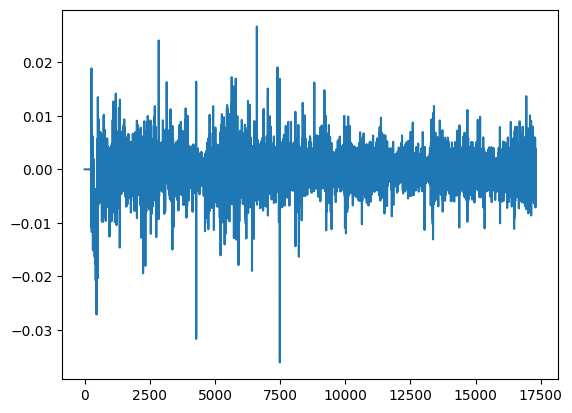

In [32]:
plt.plot(tscv.model.residuals)

In [33]:
results_df

,mape_insample,rmspe_insample,mape_test,rmspe_test
NaiveSeasonal,0.015236,0.020228,0.012357,0.014604
NaiveAVG,0.015213,0.020200,0.012335,0.014549
NaiveDrift,0.018129,0.040031,0.020579,0.022519
NaiveLast,0.015051,0.020086,0.012714,0.014946
OLS,0.001415,0.002246,0.001297,0.012351


saving: Metoda Najmniejszych Kwadratów
saving: Metoda Najmniejszych Kwadratów


<Axes: title={'center': 'Metoda Najmniejszych Kwadratów'}>

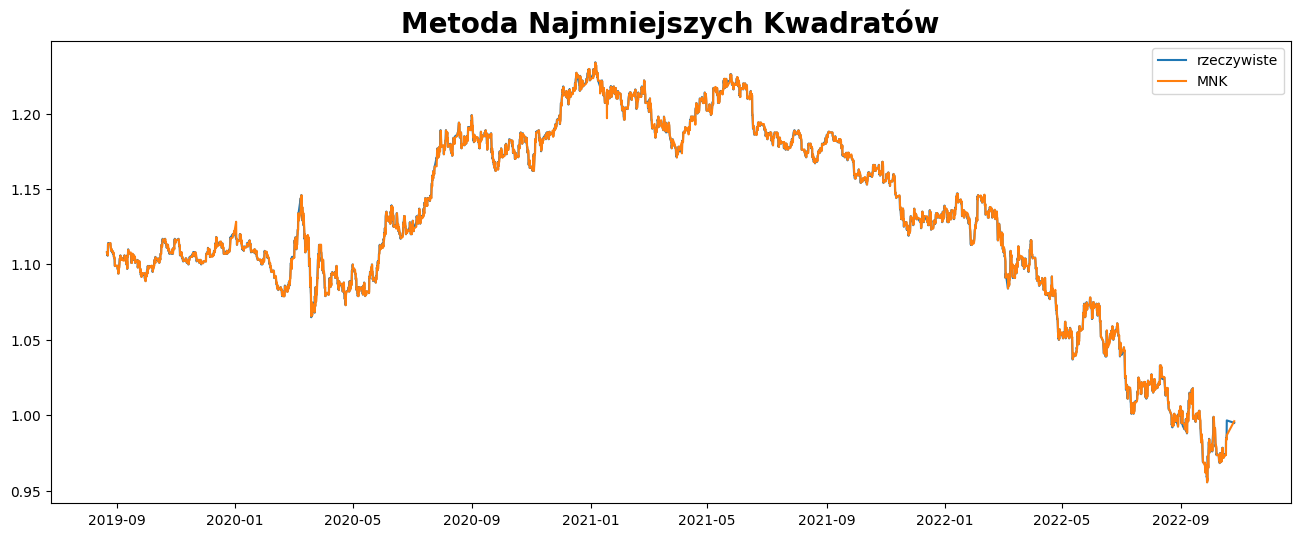

In [34]:
x = tscv.dataset.data.index[-len(tscv.predicted):]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, 'target_value'], label="rzeczywiste", title="Metoda Najmniejszych Kwadratów")
lp.plot(x, tscv.predicted, label="MNK")

## Hellwig's method for choosing features

In [35]:

eurusd = tscv.dataset.train

Drop features with negligible correlation with label, high correlation between each other and low coefficient of variation

In [36]:
FEATURES = ['Close', 'Volume', 'roi_5',
       'roi_10', 'roi_20', 'candle_body_size', 'vol_change_1', 'vol_change_2',
       'vol_change_3', 'sma_50', 'candle_size',
       'impulse', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [37]:
cv = eurusd[FEATURES].std()/eurusd[FEATURES].mean()*100
cv.apply(lambda x: f"{int(x)}%")

Close                      8%
Volume                    83%
roi_5                  -6538%
roi_10                 -4386%
roi_20                 -2960%
candle_body_size    -1214696%
vol_change_1            2992%
vol_change_2            1823%
vol_change_3            1576%
sma_50                     8%
candle_size               74%
impulse                  425%
hour_0                   226%
hour_1                   147%
hour_2                   226%
hour_3                   226%
hour_4                   226%
hour_5                   191%
hour_6                   226%
hour_7                   226%
hour_8                   226%
hour_9                   215%
hour_10                  208%
hour_11                  210%
hour_12                  210%
hour_13                  207%
hour_14                  217%
hour_15                  225%
hour_16                  225%
hour_17                  224%
hour_18                  201%
hour_19                  227%
hour_20                  227%
hour_21   

In [38]:
FEATURES.remove('sma_50')

Close and sma_50 have coefficient of variance below 10%, therefore are eliminated from possible features group

In [39]:
run_hellwig(df=eurusd, cols=FEATURES[:12])

0
12
78
298
793
1585
2509
3301
3796
4016
4082
4094
0/4095
1/4095
2/4095
3/4095
4/4095
5/4095
6/4095
7/4095
8/4095
9/4095
10/4095
11/4095
12/4095
13/4095
14/4095
15/4095
16/4095
17/4095
18/4095
19/4095
20/4095
21/4095
22/4095
23/4095
24/4095
25/4095
26/4095
27/4095
28/4095
29/4095
30/4095
31/4095
32/4095
33/4095
34/4095
35/4095
36/4095
37/4095
38/4095
39/4095
40/4095
41/4095
42/4095
43/4095
44/4095
45/4095
46/4095
47/4095
48/4095
49/4095
50/4095
51/4095
52/4095
53/4095
54/4095
55/4095
56/4095
57/4095
58/4095
59/4095
60/4095
61/4095
62/4095
63/4095
64/4095
65/4095
66/4095
67/4095
68/4095
69/4095
70/4095
71/4095
72/4095
73/4095
74/4095
75/4095
76/4095
77/4095
78/4095
79/4095
80/4095
81/4095
82/4095
83/4095
84/4095
85/4095
86/4095
87/4095
88/4095
89/4095
90/4095
91/4095
92/4095
93/4095
94/4095
95/4095
96/4095
97/4095
98/4095
99/4095
100/4095
101/4095
102/4095
103/4095
104/4095
105/4095
106/4095
107/4095
108/4095
109/4095
110/4095
111/4095
112/4095
113/4095
114/4095
115/4095
116/4095
117/40

In [40]:
tscv.dataset.data = tscv.dataset.data[['Close', 'target_value']]

Build and fit model

In [41]:
tscv.run(model=OLS())

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

(250, 1)
(500, 1)
(750, 1)
(1000, 1)
(1250, 1)
(1500, 1)
(1750, 1)
(2000, 1)
(2250, 1)
(2500, 1)
(2750, 1)
(3000, 1)
(3250, 1)
(3500, 1)
(3750, 1)
(4000, 1)
(4250, 1)
(4500, 1)
(4750, 1)
(5000, 1)
(5250, 1)
(5500, 1)
(5750, 1)
(6000, 1)
(6250, 1)
(6500, 1)
(6750, 1)
(7000, 1)
(7250, 1)
(7500, 1)
(7750, 1)
(8000, 1)
(8250, 1)
(8500, 1)
(8750, 1)
(9000, 1)
(9250, 1)
(9500, 1)
(9750, 1)
(10000, 1)
(10250, 1)
(10500, 1)
(10750, 1)
(11000, 1)
(11250, 1)
(11500, 1)
(11750, 1)
(12000, 1)
(12250, 1)
(12500, 1)
(12750, 1)
(13000, 1)
(13250, 1)
(13500, 1)
(13750, 1)
(14000, 1)
(14250, 1)
(14500, 1)
(14750, 1)
(15000, 1)
(15250, 1)
(15500, 1)
(15750, 1)


({'mean_absolute_percentage_error': 0.0013132344,
  'rmspe': 0.0020460575,
  'mean_absolute_error': 0.0015460302},
 {'mean_absolute_percentage_error': 0.0012640588,
  'rmspe': 0.012361373,
  'mean_absolute_error': 0.0014111125})

In [42]:
x, y = tscv.dataset.train['Close'].values.reshape(-1, 1), tscv.dataset.train['target_value'].values
tscv.model.summary()

'const: [0.00034428]\n coef: [[0.99969363]]\n R-score: 0.9993431597524696'

### STATSMODELS model

In [43]:
import statsmodels.api as sm
train_x, train_y = tscv.dataset.train['Close'],  tscv.dataset.train['target_value']

model = sm.OLS(train_x, train_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.058e+09
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        23:04:55   Log-Likelihood:                          79401.
No. Observations:               17303   AIC:                                 -1.588e+05
Df Residuals:                   17302   BIC:                                 -1.588e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
target_value     1.0000   1.57e-05   6.37e+04      0.000       1.000       1.000
==============================================================================
Omnibus:                     3011.223   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71628.615
Skew:                           0.035   Prob(JB):                         0.00
Kurtosis:                      12.967   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residuals normal distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Rozkład reszt MNK
saving: Wykres liniowy reszt MNK


<Axes: title={'center': 'Wykres liniowy reszt MNK'}>

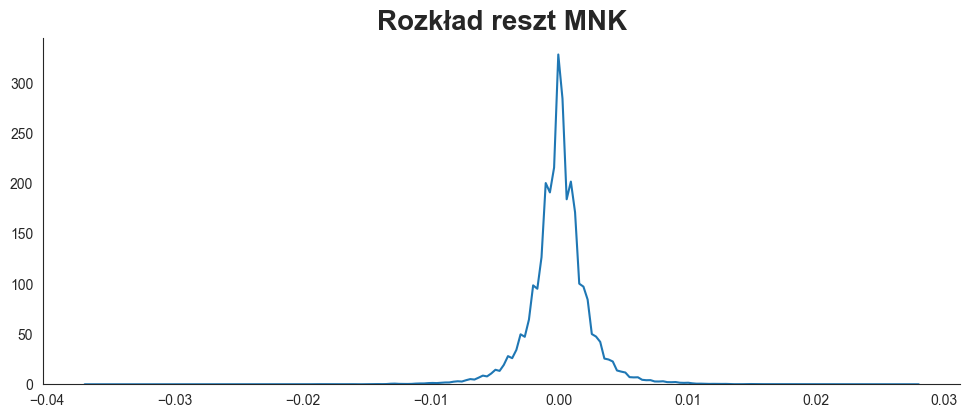

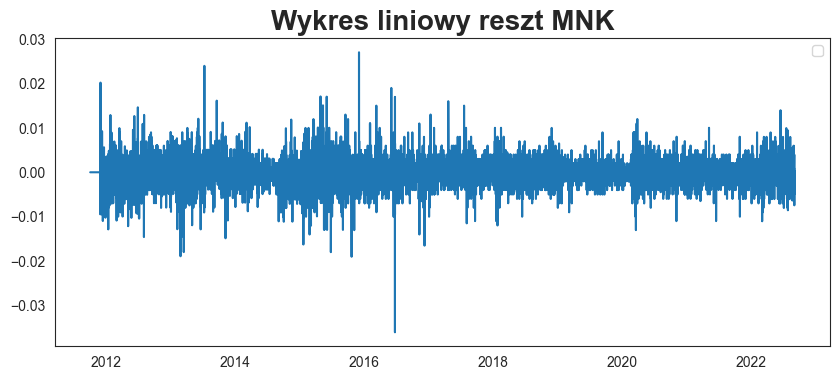

In [44]:
DistPlot().plot(tscv.residuals, title="Rozkład reszt MNK")
LinearPlot().plot(tscv.dataset.train.index, tscv.model.residuals, title="Wykres liniowy reszt MNK")

JB-Test

In [45]:
from scipy.stats import jarque_bera
jarque_bera(tscv.model.residuals)

SignificanceResult(statistic=79806.9304564773, pvalue=0.0)

In [46]:
from scipy.stats import kstest
from scipy import stats
kstest(tscv.model.residuals, stats.norm.cdf)

KstestResult(statistic=0.4941090052005655, pvalue=0.0, statistic_location=-0.013028502, statistic_sign=-1)

In [47]:
print(f"skewenes: {stats.skew(tscv.residuals)}\nkurtosis: {stats.kurtosis(tscv.residuals)}")

skewenes: -0.06852425907701501
kurtosis: 10.520306019763423


## Residuals heteroscedasity

In [48]:
fit = smf.ols('target_value ~ Close', data=tscv.dataset.train).fit()
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
breush = sms.het_breuschpagan(fit.resid, fit.model.exog)
list(zip(names, breush))

[('Lagrange multiplier statistic', 6.136977361292021),
 ('p-value', 0.013238341817818826),
 ('f-value', 6.138445172904366),
 ('f p-value', 0.01323683150493123)]

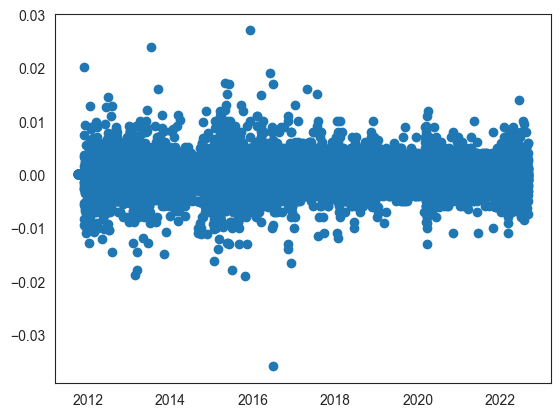

In [49]:
plt.scatter(tscv.dataset.train.index, tscv.model.residuals)

## Residuals autocorellation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: ACF reszt


<Axes: title={'center': 'ACF reszt'}>

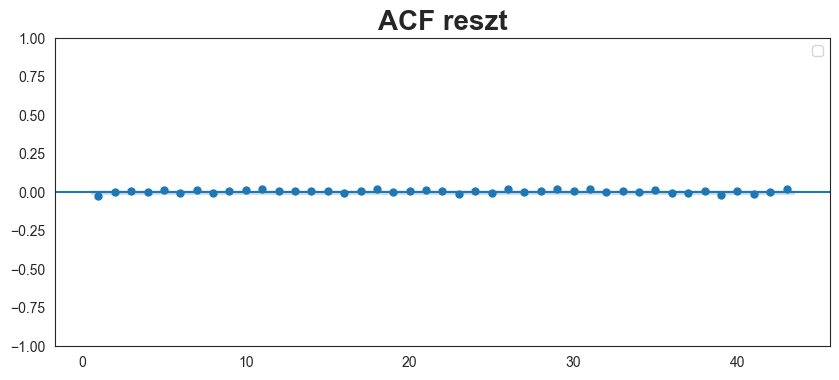

In [50]:
ACFPlot().plot(tscv.model.residuals, title="ACF reszt")

/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: PACF reszt


<Axes: title={'center': 'PACF reszt'}>

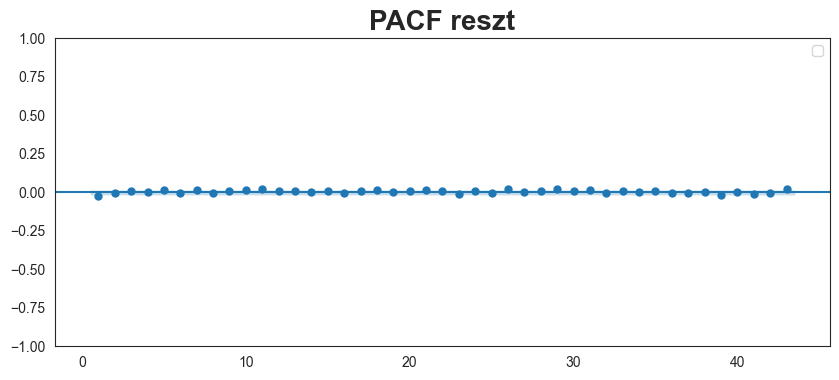

In [51]:
ACFPlot().plot(tscv.residuals, partial=True, title="PACF reszt")

In [52]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(tscv.residuals)

2.0497344

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Chow's test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Zmienna objaśniana target_value


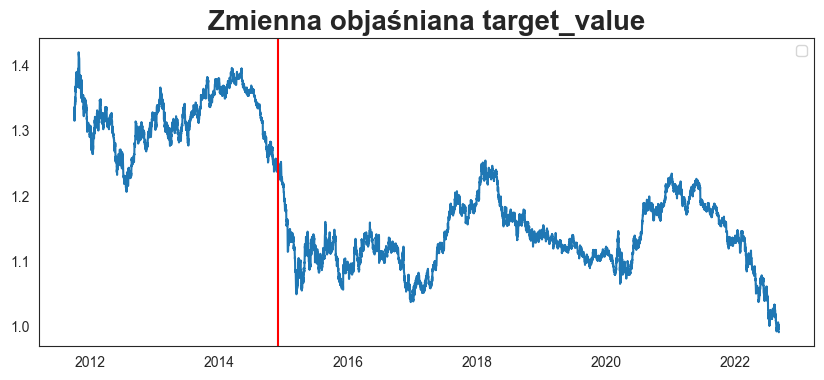

In [54]:
LinearPlot().plot(tscv.dataset.train.index, tscv.dataset.train['target_value'], title="Zmienna objaśniana target_value").\
    axvline(x=tscv.dataset.train.index[5000], color='red')

In [55]:
from chow_test import chow_test
X, y = tscv.dataset.train['Close'], tscv.dataset.train['target_value']
chow_test(X, y, last_index=4999, first_index=5000, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 4.22009222027267, P_value: 0.014712423533968955


(4.22009222027267, 0.014712423533968955)

## Models Coincidence

In [56]:
R_0 = tscv.dataset.train.corr()
R_0

,Close,target_value
Close,1.000000,0.999674
target_value,0.999674,1.000000


In [57]:
tscv.model.summary()

'const: [0.00034428]\n coef: [[0.99969363]]\n R-score: 0.9993431597524696'

## Eliminate heteroscedascity 

1. Y = a*log(X) + b

In [58]:
data = tscv.dataset.train.copy().assign(
    Close=np.log(tscv.dataset.train.Close)
)

fit = smf.ols('target_value ~ Close', data=data).fit()
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
breush = sms.het_breuschpagan(fit.resid, fit.model.exog)
list(zip(names, breush))

[('Lagrange multiplier statistic', 30.640996620080145),
 ('p-value', 3.104638996858794e-08),
 ('f-value', 30.691805469089804),
 ('f p-value', 3.068478706724065e-08)]

2. log(Y) = a*X + b

In [59]:
data = tscv.dataset.train.copy().assign(
    target_value=np.log(tscv.dataset.train.target_value)
)

fit = smf.ols('target_value ~ Close', data=data).fit()
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
breush = sms.het_breuschpagan(fit.resid, fit.model.exog)
list(zip(names, breush))

[('Lagrange multiplier statistic', 79.916891210984),
 ('p-value', 3.904939966604987e-19),
 ('f-value', 80.27843366416089),
 ('f p-value', 3.5765797183715317e-19)]

## Final model

In [60]:
tscv.run(model=OLS())

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

(250, 1)
(500, 1)
(750, 1)
(1000, 1)
(1250, 1)
(1500, 1)
(1750, 1)
(2000, 1)
(2250, 1)
(2500, 1)
(2750, 1)
(3000, 1)
(3250, 1)
(3500, 1)
(3750, 1)
(4000, 1)
(4250, 1)
(4500, 1)
(4750, 1)
(5000, 1)
(5250, 1)
(5500, 1)
(5750, 1)
(6000, 1)
(6250, 1)
(6500, 1)
(6750, 1)
(7000, 1)
(7250, 1)
(7500, 1)
(7750, 1)
(8000, 1)
(8250, 1)
(8500, 1)
(8750, 1)
(9000, 1)
(9250, 1)
(9500, 1)
(9750, 1)
(10000, 1)
(10250, 1)
(10500, 1)
(10750, 1)
(11000, 1)
(11250, 1)
(11500, 1)
(11750, 1)
(12000, 1)
(12250, 1)
(12500, 1)
(12750, 1)
(13000, 1)
(13250, 1)
(13500, 1)
(13750, 1)
(14000, 1)
(14250, 1)
(14500, 1)
(14750, 1)
(15000, 1)
(15250, 1)
(15500, 1)
(15750, 1)


({'mean_absolute_percentage_error': 0.0013132344,
  'rmspe': 0.0020460575,
  'mean_absolute_error': 0.0015460302},
 {'mean_absolute_percentage_error': 0.0012640588,
  'rmspe': 0.012361373,
  'mean_absolute_error': 0.0014111125})